# Heat Exchange Network Training

A while back I found a gem of an article describing [Neural Heat Exchanger](http://people.idsia.ch/~juergen/heatexchanger/node2.html). This post discusses an implementation of that technique.

We don't actually need backpropagation for this so [Numpy](http://www.numpy.org/) will suffice for our work here. The basic idea is that of a heat exchanger. Imagine there are two pipes as so:

```

┃  ┃          A           ┃  ┃
┃  ┃                      ┃  ┃
┃  ┗━━━━━━━━━━━━━━━━━━━━━━┛  ┃
┗━━━━━━━━━━━━━━━━━━━━━━━━━━━━┛
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃  ┏━━━━━━━━━━━━━━━━━━━━━━┓  ┃
┃  ┃                      ┃  ┃
┃  ┃          B           ┃  ┃
```

Hot water flows in pipe **A** from left to right and cold water flows in pipe **B** from right to left. If these pipes are touching, heat gets exchanged through contact.

The idea was to build two identical neural networks (feed forward), call them **A** and **B**. Now inputs are propagated through network **A** left to right and outputs are propagated through network **B** right to left. The weights in the network are updated locally and without a global update rule.

Let's first write code to make a simple feed forward network.

## Defining the network

We'll define a single *Section* class which allows us to lay down the "Pipe" in sections. It corresponds to a layer in the classic Feed Forward Network paradigm.

In [193]:
%pylab inline
plt.style.use('ggplot')
from tqdm import trange


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


class Section:
    """
    Information always flows from network_input to right.
    ---->----->----
    
    Build the pipe with sections like:
    
        Section(3) < Section(3) < Section(3)
        Section(3) > Section(3) > Section(3)
        
    The < and > denote information flow and are used to build the sections.
    """
    def __init__(self, dim):
        self.dim = dim
        self.network_input = None
        self.right = None
        self.ident = "[" + ''.join(map(str, random.choice(range(10), 3))) + "]"
    
    def takes_input(self, input):
        self.network_input = input
        self.weight = np.random.uniform(-1, 1, (input.dim, self.dim))
    
    def __call__(self, input=None):
        act = None
        if self.network_input is not None:
            act = self.network_input(input) @ self.weight
        elif input is not None:
            if not hasattr(self, 'weight'):  # In case we haven't created the weights yet
                self.weight = np.random.uniform(-1, 1, (input.shape[0], self.dim))
            act = input @ self.weight
        
        act = sigmoid(act)
        
        self.act = act
        return act
    
    def __repr__(self):
        return self.ident

Populating the interactive namespace from numpy and matplotlib


This class defines a section of a Pipe. This is analogus to a layer in a neural network. With this definition we can define the pipes F for Forward and B for Backward like so.

In [194]:
F = [Section(2) for _ in range(10)]
B = [Section(2) for _ in range(10)]

After creating the sections of the pipes we link the sections together using < and > operations. It's a nice way of defining relations between pipes. Any time you need to reorganize the pipe, you can just run a new "chain" of <>.

In [195]:
for i in range(len(F)):
    if i > 0:
        F[i].takes_input(F[i-1])
    if i < (len(F) - 1):
        B[i].takes_input(B[i+1])

To propagate information through a pipe, we take the section where we want to collect output and call it with the input data which needs to go in at the other end of the pipe. For the forward pipe, we provide it with an instance of **X** and generate an instance of **Y**.

Let's try and predict if the numbers are within a circle of radius 0.8.

In [196]:
x = np.random.uniform(-1, 1, (500, 2))
y =(np.sqrt(np.power(x, 2).sum(axis=1)) <= 0.8)

To visualize our data we can plot it to see the 1s and 0s.

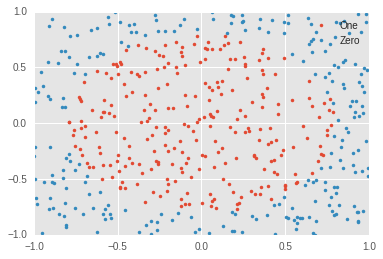

In [197]:
plt.plot(x[y,0], x[y,1], '.', label='One')
plt.plot(x[~y,0], x[~y,1], '.', label='Zero')
plt.legend()

In [198]:
y = y.astype(float).reshape((-1, 1))
y = np.concatenate([y, y], axis=1).astype(float)

# For easiness sake we will simply duplicate the y signal to shape 2,2

out_section = F[-1]
predicted_output = out_section(x[1])
predicted_output

array([0.57820847, 0.60292775])

Similarly for the backward pipe, however here we provide it with an instance of **Y** and generate an instance of **X**

In [199]:
out_section = B[0]
predicted_input = out_section(y[1])
predicted_input

array([0.61178636, 0.57108236])

## Heat Exchange!

Now that we have the network defined and the "pipes" laid out, we can begin training this heat exchange network.

The update rule defined by Jürgen Schmidhuber says that each pipe section should try to minimize the distance between itself, it's previous section and to the corresponding section in the other pipe.

We'll first write a function which takes in a section and it's corresponding "input activation" and "side activation" and adds an update to it's weights. This is kind of like calculating gradients. For now we will keep in line with that method of doing things since we're already failiar with the loop of training which is as

1. Forward Pass
2. Gradient Calculation
3. Weight Update

For now we will simply follow this loop.

In [200]:
def update(net, prev_act, side_act, step):
    """
    Update the network's weights to look more like the ones previous to it
    and beside it
    """
    update_prev = (prev_act - net.act)
    update_side = (side_act - net.act)
    total_update = update_prev + update_side
    
    credit_assignment = (net.weight / net.weight.sum(axis=0))
    try:
        total_update = total_update.reshape(credit_assignment.shape)
    except:
        pass
    
    net.wt_update = credit_assignment * total_update * step
    return net

def learn(F, B, a, b, step=0.001):
    """
    This function updates the network on examples a and b
    """
    # Calculate updates for F and B
    F[-1](a)
    B[0](b)
    for i in range(len(F)):
        if i == 0:
            lastf = a  # Input was the last activation
        else:
            lastf = F[i-1].act 
        if i == (len(F) - 1):
            lastb = b  # output was the last activation
        else:
            lastb = B[i+1].act
        update(F[i], lastf, B[i].act, step)
        update(B[i], lastb, F[i].act, step)
    # perform updates
    for f in F:
        f.weight += f.wt_update
        f.wt_update = None
    for b in B:
        b.weight += b.wt_update
        b.wt_update = None

In [201]:
weight_log = []
for epoch in trange(200):
    weight_log.append([[n.weight.copy() for n in D] for D in [F, B]])
    order = list(range(len(x)))
    random.shuffle(order)
    for i in order:
        a, b = x[i], y[i]
        learn(F, B, a, b)

100%|██████████| 200/200 [00:45<00:00,  4.39it/s]


Let's see the weights of the network. What we'll do is plot the weights of the networks in a matrix and color by magnitude. For example in the matrix below, The top 2 rows belong to the weights of the Forward network and the bottom two rows belong to the backward network.

We can visualize them now.

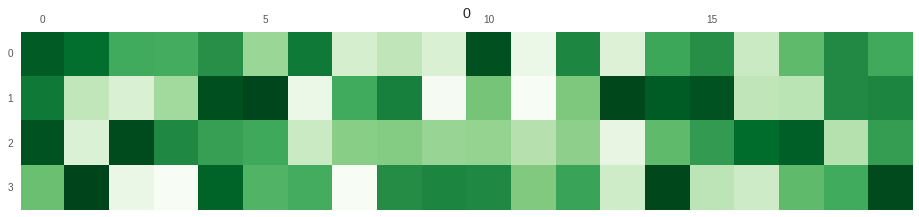

In [202]:
plt.style.use('ggplot')
def compare(a, b, only_after=True, cmap='Greens'):
    i = a
    rep = np.concatenate([np.concatenate(weight_log[i][0]), np.concatenate(weight_log[i][1])], axis=1)
    before = rep.T.copy()

    i = b
    rep = np.concatenate([np.concatenate(weight_log[i][0]), np.concatenate(weight_log[i][1])], axis=1)
    after = rep.T.copy()
    if not only_after:
        ax = plt.subplot(2, 1, 1)
        
        plt.subplots(figsize=(15, 7))

        ax.matshow(np.concatenate([before, after]),
                     cmap=cmap)

        plt.xlabel('Layer Weights')
        plt.ylabel('[FB] at t=0 (lower),  [FB] at t=-1 (upper)')
        plt.title('Lower4 = {}, Upper4 = {}'.format(a, b))
        ax = plt.subplot(2, 1, 2)
        ax.matshow(after, cmap=cmap)
    else:
        plt.matshow(after, cmap=cmap)
    plt.grid('off')
    plt.title(str(b))
compare(0, 0)

Those were the random weights at the beginning. We'll see some more steps.

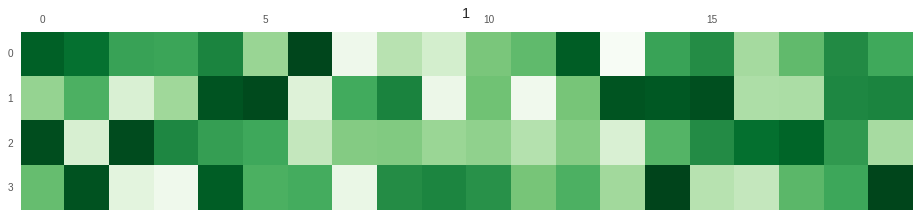

In [204]:
compare(0, 1)

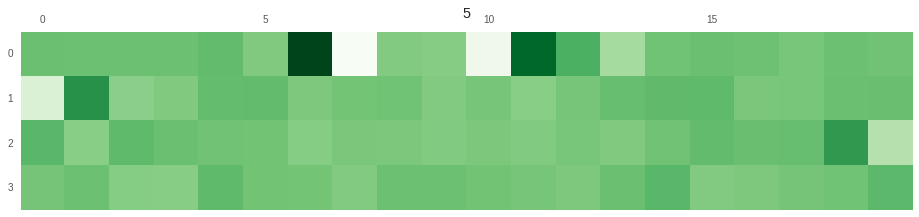

In [205]:
compare(0, 5)

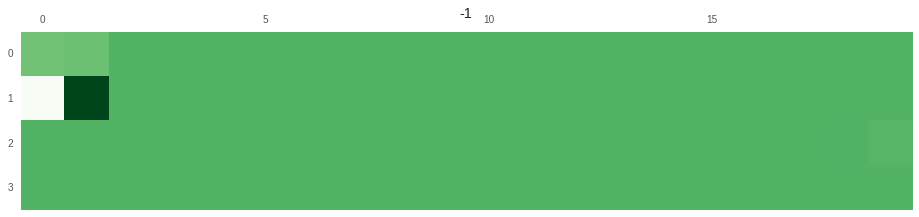

In [206]:
compare(0, -1)

We see some changes in the weights as the network learns.Perhaps a better way of seeing the change would be a video of the learning process. We will quickly save these images and create a video from them.

In [207]:
!mkdir plots
for i in trange(len(weight_log)):
    compare(0, i)
    plt.savefig('plots/{}.png'.format(i))
    plt.close()

100%|██████████| 200/200 [00:32<00:00,  6.17it/s]


In [208]:
%%capture
! rm test.mp4
! ffmpeg -r 10 -f image2 -s 700x200 -i plots/%d.png -vcodec libx264 -crf 25  -pix_fmt yuv420p test.mp4
! rm -rf plots

In [209]:
! mv test.mp4 ../videos/test.mp4

<video width=800 controls src="https://www.arjoonn.com/static/videos/test.mp4" />

The network does attain some semblance of a "equilibrium temperature", though I'm not sure if that is indeed what is happening. Perhaps someone with better understanding can come along and find the mistakes that were done in this post.

One of the nice things that I noticed about the heat Exchange network was that there is no need to stick to the "forward-gradient-update" loop. Each node can perform it's update on the fly since all it actually needs is access to the input and it's "side pipe".

With that knowledge, we can see how easily parallelizable this technique is. Even with all the massive parallelization in neural networks that we see today, there is still a need to update the weights with a globally synchronized rule. Here that is not the case.